# Lab 2 AI for Multimodal Cyberharassment Detection



With previous lab learning, you should have some knowledge about how to develop an AI model to detect cyberbullying lauguage. In this lab, we will keep learning how AI can be developed to detect cyberbullying. We will use a publicly available test dataset of cyberbullying images, and deploy an pre-trained AI model to automatically detect cyberbullying images.
Approach towards analysing the cyber bullying in images in a dataset, there are three steps:
1. Understand and identify the factors related to cyberbullying in images.
2. Load the pre-trained model.
3. Evaluate the pre-trained model with the cyberbullying image dataset.
 - Get the results of accuracy, precision, recall and F1-score
 - plot out the confusion matrix figure
 - plot the ROC curve and calculate the AUC value

## Download the pre-trained model, test dataset and the dependencies

First, we need to download the pre-trained model and the test dataset used in the lab. Just hit the 'play' button run the code below.

In [1]:
 # download the model and dataset
!wget -O auxes_17.pt https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt # model checkpoints
!wget -O cyberbullying_data.zip https://github.com/cuadvancelab/materials/blob/main/lab2/cyberbullying_data.zip?raw=true # test dataset

--2024-11-10 13:55:34--  https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.157
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2024-11-10 13:55:34--  https://buffalo.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2024-11-10 13:55:35--  https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112.186.157
Connecting to buffalo.app.box.com (buffalo.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Fo

In [2]:
# unzip the test data
%%capture
!unzip "/content/cyberbullying_data.zip" -d "/content"

Let's import all the dependencies in our iPython notebook

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

In [4]:
import pickle
import gzip
import sys
import time
import numpy as np
import math
import os
import random
from skimage import io, transform

## How to identify cyberbullying in images

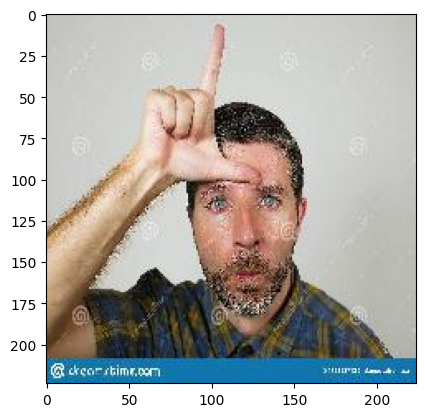

In [5]:
# @title An example image
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img

# reading the image
testImage = img.imread('/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/7.s-s-unshaven-sad-ashamed-man-doing-loser-sign-hand-fingers-his-front-funny-depressed-face-expression-s-139158713.jpg')

# displaying the image
plt.imshow(testImage)

**5 FACTORS to measurement cyberbulling in images**
- Body-pose
- Facial Emotion
- Object
- Gesture
- Social Factors

<img src="https://github.com/cuadvancelab/materials/blob/main/lab2/factors.png?raw=true" alt="drawing" width="600"/>

The follow table shows the analysis of cyberbulling factors in images. Higher value of cosine similarity indicates higher correlation.

| Factor        | Attribute           |  Cyberbulling  |  Non-cyberbulling  |  Description  |
| ------------- |:----------:|:-----:|:-----:| ------------- :|
| Body-pose      | Front pose <br> Non-front pose | 0.86<br>0.50 | 0.53 <br> 0.84 | Pose of subject in image is towards the viewer |
| Emotion      | Joy <br> Sorrow <br> Anger <br> Surprise | 0.34<br>0.02<br>0.09<br>0.07 | 0.25<br>0.02<br>0.04<br>0.05 | Facial emotion of subject in image|
| Gesture      | Hand gesture <br> No hand gesture | 0.71<br>0.70 | 0.32 <br> 0.94 | Hand gesture made by subject in imager |
| Object      | Threatening object <br> No threatening object | 0.33<br>0.94 | 0.06 <br> 0.99 | Threatening object present in image |
| Social      | Anti-LGBT <br> Anti-black racism | 0.45<br>0.03 | 0.06 <br> 0.00 | Anti-LGBT symbols and anti-black racism in image |

More details can be found in 2021 NDSS paper: <em>**Towards Understanding and Detecting Cyberbullying in Real-world Images.**</em> [link](https://www.ndss-symposium.org/wp-content/uploads/ndss2021_7C-4_24260_paper.pdf)

## Load datasets

Now, let's run the subsequent codes to load your data from a predefined
class

In [6]:
class PosesDataset(Dataset):

  def __init__(self, root_dir, poses_dir, auxes_dir):

    self.samples = []
    self.root_dir = root_dir
    self.poses_dir = poses_dir
    self.auxes_dir = auxes_dir

    for _, _, cb_images in os.walk(self.root_dir + 'cyberbullying'): break
    for _, _, non_cb_images in os.walk(self.root_dir + 'non_cyberbullying'): break
    for _, _, cb_poses in os.walk(self.poses_dir + 'cyberbullying'): break
    for _, _, non_cb_poses in os.walk(self.poses_dir + 'non_cyberbullying'): break

    for i in cb_images:
      self.samples.append((self.root_dir + 'cyberbullying/' + i, self.poses_dir + 'cyberbullying/' + i, self.auxes_dir + 'cyberbullying/' + i, 1))

    for i in non_cb_images:
      self.samples.append((self.root_dir + 'non_cyberbullying/' + i, self.poses_dir + 'non_cyberbullying/' + i, self.auxes_dir + 'non_cyberbullying/' + i, 0))


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name, pose_name, aux_name, label = self.samples[idx]
    image = io.imread(img_name)

    aux = pickle.load(open(aux_name + '.p', 'rb'))
    aux = torch.tensor(aux)

    # drop the alpha channel for some images
    if image.shape == (224, 224):
      # handle grayscale images
      image = np.stack([image, image, image], axis=2)

    if image.shape == (224, 224, 4):
      image = image[:,:,:3]

    image = image.transpose((2, 0, 1)) # C X H X W
    pose = io.imread(pose_name)
    if pose.shape != (224, 224):
      pose = pose[:,:,0]
    pose = np.expand_dims(pose, axis = 0)
    image = np.concatenate((image, pose), axis = 0)
    sample = {'image': torch.from_numpy(image.copy()).float() / 255, 'aux': aux, 'label': label}
    return sample

In [7]:
test_set = PosesDataset('cyberbullying_data/cyberbullying_data_splits_clean/test/', 'cyberbullying_data/cyberbullying_poses/test/', 'cyberbullying_data/cyberbullying_data_auxes/test/')
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = True)

## Define an AI model for cyberbullying image detection  

We will use GPU to test our AI if it is available.

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Our AI model prediction process looks like the following figure.
<img src="https://github.com/cuadvancelab/materials/blob/main/lab2/model.png?raw=true" alt="drawing" width="700"/>

In our AI model, we combine the **low level image features** with the **cyberbulling factors** identified before. We combine these features using feature fusion techniques.

We use the `VGG16` pre-trained model for image features `CNN` and use a multi-layer perceptron model `MLP` for the factors related features, and combine the feature vectors from both these models using late fusion.

Let's load the pre-trained model to test its capability

In [9]:
# load vgg16 pre-trained model
orig = models.vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.8MB/s]


Follow code demonstrates the structure of the cyberbullying image detection model

In [10]:
class CB(nn.Module):
  def __init__(self):
    super(CB, self).__init__()
    self.conv1 = nn.Conv2d(4, 3, 1)
    self.f = nn.Sequential(*list(orig.features.children()))
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.aux_classifier = nn.Sequential(
      nn.Linear(25097, 1024),
      nn.ReLU(),
      nn.Linear(1024, 25088),
      nn.ReLU()
    )
    self.classifier = nn.Sequential(*list(orig.classifier.children()))
    self.classifier[-1] = nn.Linear(4096, 2)
    self.sig = nn.Sigmoid()

  def forward(self, x, aux):
    x = self.conv1(x)
    x = self.f(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = torch.cat((x, aux), dim = 1)
    x = self.aux_classifier(x)
    x = self.classifier(x)
    x = self.sig(x)


    return x


In [11]:
# let's load this model
model_basic = CB()
model_basic = model_basic.to(device)

- - - -
**<font color='red'>Task 1:</font>
Write code to print out the accuracy of the basic model**
- - - -

In [12]:
correct, incorrect, total = 0., 0., 0.

for i_v, data_v in enumerate(test_loader):
  x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
  x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
  y_test_ = model_basic(x_test, aux_test) # forward pass for the basic model
  _, predicted = torch.max(y_test_.data, 1)
  total += y_test.size(0)
  correct += (predicted == y_test).sum().item()

In [18]:
# TODO: Write code to print out the accuracy of the base model
# Your code here:
print(correct)
print(incorrect)
print(total)


17.0


## Load the pre-trained model

To load our pre-trained model, we can pass the checkpoints to the model so that we can have our pre-trained model which is ready to detect cyberbullying images

In [14]:
model = torch.load("auxes_17.pt")
model = model.to(device)

print("The pre-trained model for cyberbullying image detection is ready.")

running_loss = []
criterion = nn.CrossEntropyLoss()
correct, incorrect, total = 0., 0., 0. # reset the parameters

<ipython-input-14-169d53a0b4f3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("auxes_17.pt")


The pre-trained model for cyberbullying image detection is ready.


## Generate the detection resuls for test data

Now, it's time to evaulate the pre-trained model's capability with our test dataset

In [15]:
with torch.no_grad():
  for i_v, data_v in enumerate(test_loader):
    x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
    x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
    y_test_ = model(x_test, aux_test) # forward pass for the pre-trained model
    running_loss.append(criterion(y_test_, y_test))
    _, predicted = torch.max(y_test_.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()


- - - -
**<font color='red'>Task 2:</font>
Write code to generate result report contains: Accuracy, Precision, Recall and F1-Score**
- - - -
reference link: https://en.wikipedia.org/wiki/F-score
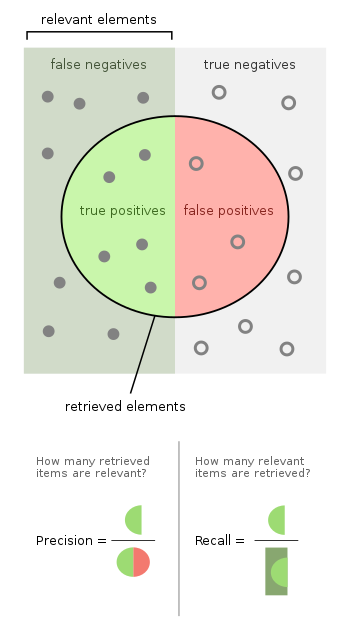

In [16]:
# get the acc, precision, recall, f1 score for the test set

tp, tn, fp, fn = 0, 0, 0, 0

model.eval()
with torch.no_grad():
    for i_v, data_v in enumerate(test_loader):
        x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
        x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
        y_test_ = model(x_test, aux_test) # forward pass for the fine-tuned model
        _, predicted = torch.max(y_test_.data, 1)
        if y_test == 1 and predicted == 1:
            tp += 1
        elif y_test == 1 and predicted == 0:
            fn += 1
        elif y_test == 0 and predicted == 1:
            fp += 1
        elif y_test == 0 and predicted == 0:
            tn += 1

print(tp, tn, fp, fn)

8 9 1 2


In [17]:
# TODO: Complete the following code to calculate the accuracy, precision, recall and F1 score.
acc =
precision =
recall =
f1 =

print('The accuracy for test dataset is: {}%'.format(acc * 100))
print('The precision for test dataset is: {}%'.format(precision * 100))
print('The recall for test dataset is: {}%'.format(recall * 100))
print('The f1 score for test dataset is: {}%'.format(f1 * 100))

SyntaxError: invalid syntax (<ipython-input-17-28cde3f2731f>, line 2)


- - - -
**<font color='red'>Task 3:</font>
Complete code to calculate the confusion matrix**
- - - -

In [ ]:
# Complete the following code to get the confusion matrix for the test set
# get the confusion matrix for the test set
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

# TODO: Write the code to get the y_true and y_pred lists for the test set
# your code here:



- - - -
**<font color='red'>Task 4:</font>
Write code to plot the confusion matrix**
- - - -

In [ ]:
# get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# TODO: Write the code to plot the confusion matrix
# your code here:


A receiver operating characteristic curve (**ROC curve**), is a graphical plot that illustrates the performance of a binary classifier model.

The ROC curve is the plot of the true positive rate (TPR) against the false positive rate (FPR) at each threshold setting.

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).


- - - -
**<font color='red'>Task 5:</font>
Write code to plot the ROC curve** (you are allowed to borrow any python tools, such as [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)) and print out the AUC value.
- - - -

In [ ]:
# TODO: Write the code to plot the ROC curve
# your code here:


## Let's check with one instance

To better understand the performance, you can try to visualize one instance in the dataset

In [ ]:
# check how many test data samples we have
print(f"we have {len(test_set)} samples in our test dataset, you can choose any of them to see the prediction.")

In [ ]:
#@markdown Select a number to view the image and its label.

picture_index  = "7" #@param [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
index = int(picture_index)
instance = test_set[index]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(test_set.samples[index][0])
imgplot = plt.imshow(img)
plt.show()
annot_label = "cyberbullying" if test_set[index]['label']==1 else "non-cyberbullying"
print('')
print("The label of this image is: {}".format(annot_label))

Run the following code cell to check the AI's prediction

In [ ]:
# check if the prediction is correct
instance_image, instance_label, instance_aux = instance['image'].to(device), torch.tensor(instance['label']).to(device, dtype = torch.long), instance['aux'].to(device, dtype = torch.float)

output = model(instance_image.unsqueeze(0), instance_aux.unsqueeze(0)).data
_, prediction = torch.max(output.data, 1)
predict_label = "cyberbullying" if prediction.item()==1 else "non-cyberbullying"
comparision = "correct" if prediction==instance_label else "not correct"

print("The AI prediction for this image is: {}, which is {}!".format(predict_label, comparision))